# Implementation of DLRM (10%/Regular/FedPer) 

## Imports

In [1]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -q

import tensorflow as tf
from tensorflow.keras.metrics import AUC
# syft absolute
import syft as sy

sy.requires(SYFT_VERSION)

import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Layer, Input, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


✅ The installed version of syft==0.8.4 matches the requirement >=0.8.2b0 and the requirement <0.9


## Load and preprocess the data

In [2]:
# Set the seed for reproducibility
np.random.seed(42)

# Total number of rows in the dataset (excluding the header)
total_rows = 1364729

# Number of rows to load - 10% of the total rows
rows_to_load = total_rows // 10

# Generate a sorted list of random indices to skip, aiming to load about 10% of the dataset
skip_rows = np.sort(np.random.choice(np.arange(1, total_rows + 1), size=(total_rows - rows_to_load), replace=False))

# Define the column names
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]

# Load the dataset, skipping the selected rows
df = pd.read_csv('/Users/alex/Thesis/New Dataset/train.txt', sep='\t', names=columns, skiprows=skip_rows).fillna(0)

# Check the loaded data
print(f"Loaded rows: {len(df)}")

Loaded rows: 136473


In [3]:
# Preprocess Dense Features
dense_cols = [c for c in columns if 'I' in c]
df[dense_cols] = preprocessing.StandardScaler().fit_transform(df[dense_cols])
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.134357,-0.264834,-0.037551,-0.665336,-0.251022,-0.285512,0.022657,-0.416195,0.391602,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,1,-0.289223,-0.057509,-0.047134,1.216693,-0.207498,-0.015080,-0.181215,0.173649,0.627000,...,e5ba7672,df00d249,0,0,f520f961,0,32c7478e,27b60b01,0,0
2,0,-0.289223,-0.267527,-0.043940,0.840287,-0.162964,0.024984,-0.218283,0.284245,-0.045566,...,e5ba7672,2a93f7c8,0,0,5dc9a057,0,32c7478e,90b6276f,0,0
3,0,-0.289223,-0.216369,-0.024773,-0.288930,-0.057373,4.218350,-0.199749,-0.453060,1.261135,...,8efede7f,5aed7436,21ddcdc9,a458ea53,3c1a8dd8,0,3a171ecb,3fdb382b,b9266ff0,49d68486
4,0,-0.289223,-0.219061,-0.015190,0.338413,-0.138342,-0.151965,-0.218283,-0.047543,-0.204100,...,07c540c4,0f2f9850,5fd56cf9,b1252a9d,96725293,0,32c7478e,2702453c,8b8de563,303cea07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136468,0,0.175374,-0.262142,-0.008801,1.216693,-0.269388,-0.232093,-0.051478,0.063053,1.208290,...,3486227d,ae09efbe,0,0,80d4b4fb,c9d4222a,423fab69,5ddc2c4c,0,0
136469,0,-0.134357,-0.259449,0.320225,-0.414399,-0.270190,-0.081853,-0.236817,0.616032,-0.386654,...,e5ba7672,6fc84bfb,0,0,5155d8a3,0,423fab69,ded4aac9,0,0
136470,0,-0.134357,-0.270219,-0.053523,-0.665336,-0.252656,-0.298867,-0.236817,-0.489925,-0.477931,...,d4bb7bd8,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
136471,0,-0.134357,-0.235216,-0.034357,0.087476,-0.270220,-0.262141,-0.236817,-0.231869,-0.444302,...,d4bb7bd8,e4ca448c,0,0,f8af07d5,ad3062eb,32c7478e,9117a34a,0,0


In [4]:
# Preprocess Categorical Features
cat_cols = [c for c in columns if 'C' in c]
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, df[col].unique()), cat_cols)
}
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping.get)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.134357,-0.264834,-0.037551,-0.665336,-0.251022,-0.285512,0.022657,-0.416195,0.391602,...,0,0,0,0,0,0,0,0,0,0
1,1,-0.289223,-0.057509,-0.047134,1.216693,-0.207498,-0.015080,-0.181215,0.173649,0.627000,...,0,1,1,1,1,0,1,1,1,1
2,0,-0.289223,-0.267527,-0.043940,0.840287,-0.162964,0.024984,-0.218283,0.284245,-0.045566,...,0,2,1,1,2,0,1,2,1,1
3,0,-0.289223,-0.216369,-0.024773,-0.288930,-0.057373,4.218350,-0.199749,-0.453060,1.261135,...,1,3,0,2,3,0,0,3,2,2
4,0,-0.289223,-0.219061,-0.015190,0.338413,-0.138342,-0.151965,-0.218283,-0.047543,-0.204100,...,2,4,2,0,4,0,1,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136468,0,0.175374,-0.262142,-0.008801,1.216693,-0.269388,-0.232093,-0.051478,0.063053,1.208290,...,8,91,1,1,7735,2,3,81,1,1
136469,0,-0.134357,-0.259449,0.320225,-0.414399,-0.270190,-0.081853,-0.236817,0.616032,-0.386654,...,0,148,1,1,1521,0,3,119,1,1
136470,0,-0.134357,-0.270219,-0.053523,-0.665336,-0.252656,-0.298867,-0.236817,-0.489925,-0.477931,...,6,475,1,1,70,0,1,16,1,1
136471,0,-0.134357,-0.235216,-0.034357,0.087476,-0.270220,-0.262141,-0.236817,-0.231869,-0.444302,...,6,280,1,1,46292,1,1,68,1,1


In [5]:
label_counts = df.groupby('label')['I1'].count()
print(f'Baseline: {max(label_counts.values) / sum(label_counts.values) * 100}%')

Baseline: 74.8177295142629%


In [6]:
# Shuffle the DataFrame rows
df_shuffled = df.sample(frac=1).reset_index(drop=True)

# Calculate the index for splitting
first_split = int(len(df_shuffled) * 1/2)
second_split = first_split + int(len(df_shuffled) * 1/2)

# Split the DataFrame into two parts
df1 = df_shuffled.iloc[:first_split]
df2 = df_shuffled.iloc[first_split:second_split]

df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

# Verifying the splits
print(f"Total records: {len(df)}")
print(f"df1 records: {len(df1)}")
print(f"df2 records: {len(df2)}")

Total records: 136473
df1 records: 68236
df2 records: 68236


In [7]:
dense_cols = [c for c in df.columns if 'I' in c]
cat_cols = [c for c in df.columns if 'C' in c]
fixed_embedding_size = 455000
emb_counts = [len(df[c].unique()) for c in cat_cols]

## Data Owner 1

In [8]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [9]:
def MLP(arch, activation='relu', out_activation='sigmoid'): 
  mlp = tf.keras.Sequential()
  for units in arch[:-1]:
    mlp.add(tf.keras.layers.Dense(units, activation=activation))
  mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))
  return mlp

class BaseLayerModel(tf.keras.Model):
  def __init__(self, embedding_sizes, embedding_dim, arch_bot):
    super(BaseLayerModel, self).__init__()
    self.emb = [Embedding(size, embedding_dim, trainable=True) for size in embedding_sizes]
    self.bot_nn = MLP(arch_bot, out_activation='sigmoid')

  def call(self, inputs):
    input_dense, input_cat = inputs
    emb_x = [E(tf.expand_dims(x, axis=-1)) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
    dense_x = self.bot_nn(input_dense)
    return dense_x  # Correct for binary classification

# Instantiate and compile the base layer model
base_layer_model = BaseLayerModel(
  embedding_sizes=emb_counts,
  embedding_dim=2,
  arch_bot=[8, 2]
)

base_layer_model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy', AUC(name='auc')]
)

In [10]:
BATCH_SIZE = 128

history = base_layer_model.fit(
  ds_train.batch(BATCH_SIZE),
  validation_data=ds_valid.batch(BATCH_SIZE),
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
  epochs=5,
  verbose=1,
)

Epoch 1/5


427/427 [==============================] - 21s 39ms/step - loss: 0.7107 - accuracy: 0.5453 - auc: 0.5365 - val_loss: 0.6856 - val_accuracy: 0.6596 - val_auc: 0.6353
Epoch 2/5
427/427 [==============================] - 10s 23ms/step - loss: 0.6613 - accuracy: 0.7030 - auc: 0.6970 - val_loss: 0.6349 - val_accuracy: 0.7299 - val_auc: 0.7385
Epoch 3/5
427/427 [==============================] - 9s 22ms/step - loss: 0.6203 - accuracy: 0.7344 - auc: 0.7508 - val_loss: 0.6018 - val_accuracy: 0.7358 - val_auc: 0.7675
Epoch 4/5
427/427 [==============================] - 8s 19ms/step - loss: 0.5894 - accuracy: 0.7475 - auc: 0.7739 - val_loss: 0.5839 - val_accuracy: 0.7296 - val_auc: 0.7750
Epoch 5/5
427/427 [==============================] - 8s 18ms/step - loss: 0.5685 - accuracy: 0.7491 - auc: 0.7858 - val_loss: 0.5574 - val_accuracy: 0.7461 - val_auc: 0.7935


In [11]:
base_layer_model.summary()

Model: "base_layer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple             

In [12]:
results = base_layer_model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 3s 11ms/step - loss: 0.5608 - accuracy: 0.7498 - auc: 0.7908
Loss: 0.5608190298080444, Accuracy: 0.7497939467430115, AUC: 0.7908199429512024


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.710726,0.545266,0.536500,0.685604,0.659582,0.635257
1,0.661260,0.702993,0.697008,0.634859,0.729938,0.738513
2,0.620275,0.734356,0.750839,0.601781,0.735801,0.767465
3,0.589370,0.747490,0.773905,0.583856,0.729571,0.775001
4,0.568478,0.749084,0.785789,0.557420,0.746061,0.793537


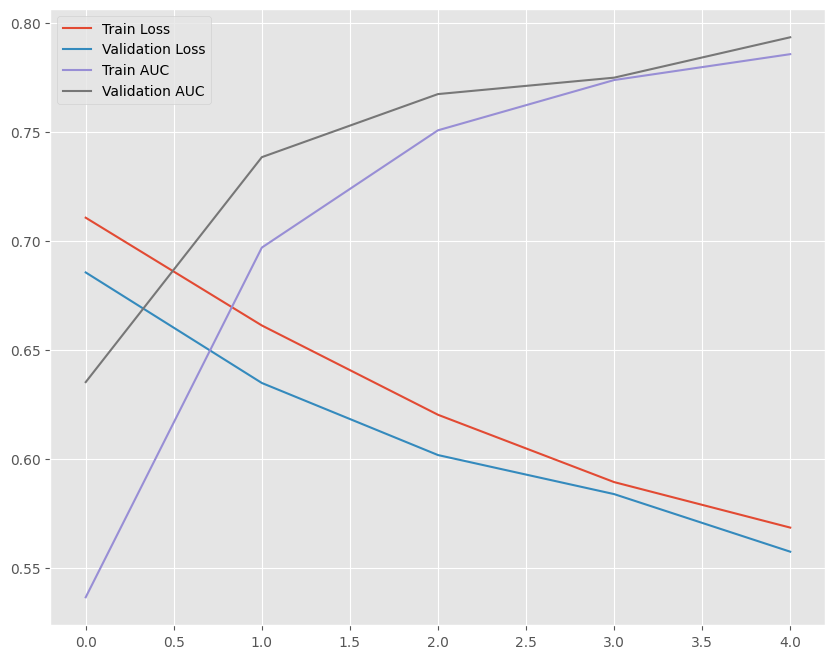

Validation AUC: 0.7929


In [13]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = base_layer_model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = base_layer_model.metrics_names.index('auc')
auc_score_baseline1 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline1:.4f}")

In [14]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_1 = {v.name: v.numpy() for v in base_layer_model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_1 = add_noise_to_weights(model_weights_dict_1, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [19]:
node = sy.orchestra.launch(name="test-domain-1", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-1 server on 0.0.0.0:53826
Waiting for server to start.

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


............

INFO:     Started server process [47044]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:53826 (Press CTRL+C to quit)


. Done.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=649832e58fb64586b7757ee613acceab in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:59325 - "GET /api/v2/metadata HTTP/1.1" 200 OK



Login to the Domain

In [20]:
domain_client = node.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:59327 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:59327 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-1: High-side Domain> as GUEST
INFO:     127.0.0.1:59327 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:59327 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:59333 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-1: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [21]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_1)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 1e46c7034aca4502991e476ef06c01b2


In [22]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:59335 - "POST /api/v2/api_call HTTP/1.1" 200 OK
1e46c7034aca4502991e476ef06c01b2


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [23]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:59338 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59327 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [24]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/49edea60befb41fbae12191cfc9f6439.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=10ff95c89a08454fbc230be7847dc9e2 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_5351: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:59352 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59354 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_5351
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [25]:
request = domain_client.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:59365 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59368 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:59370 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59373 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59375 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59377 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59380 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59382 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59384 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [26]:
request.approve()

INFO:     127.0.0.1:59368 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:59386 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59388 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59392 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59394 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59396 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59400 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59402 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-1
INFO:     127.0.0.1:59406 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request a92199189196474897b26858ad959aa3 changes applied

In [27]:
domain_client._api = None
_ = domain_client.api

INFO:     127.0.0.1:59368 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [28]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/9c639fab0fa146cd8e4b27d07ee75dd9.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=7045e70c3de0431b894a271e2cd533cc in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_5777: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:59428 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59430 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_5777
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [29]:
if node.node_type.value == "python":
    node.land()

## Data Owner 2

In [30]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [31]:
def MLP(arch, activation='relu', out_activation='sigmoid'):  # Ensure this matches your task
  mlp = tf.keras.Sequential()
  for units in arch[:-1]:
    mlp.add(tf.keras.layers.Dense(units, activation=activation))
  mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))
  return mlp

class BaseLayerModel(tf.keras.Model):
  def __init__(self, embedding_sizes, embedding_dim, arch_bot):
    super(BaseLayerModel, self).__init__()
    self.emb = [Embedding(size, embedding_dim, trainable=True) for size in embedding_sizes]
    self.bot_nn = MLP(arch_bot, out_activation='sigmoid')

  def call(self, inputs):
    input_dense, input_cat = inputs
    emb_x = [E(tf.expand_dims(x, axis=-1)) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
    dense_x = self.bot_nn(input_dense)
    return dense_x  # Correct for binary classification

# Instantiate and compile the base layer model
base_layer_model = BaseLayerModel(
  embedding_sizes=emb_counts,
  embedding_dim=2,
  arch_bot=[8, 2]
)

base_layer_model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy', AUC(name='auc')]
)

In [32]:
BATCH_SIZE = 128

history = base_layer_model.fit(
  ds_train.batch(BATCH_SIZE),
  validation_data=ds_valid.batch(BATCH_SIZE),
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
  epochs=5,
  verbose=1,
)

Epoch 1/5


427/427 [==============================] - 6s 9ms/step - loss: 0.6827 - accuracy: 0.6882 - auc: 0.6830 - val_loss: 0.6632 - val_accuracy: 0.7175 - val_auc: 0.7122
Epoch 2/5
427/427 [==============================] - 3s 8ms/step - loss: 0.6470 - accuracy: 0.7221 - auc: 0.7251 - val_loss: 0.6218 - val_accuracy: 0.7424 - val_auc: 0.7486
Epoch 3/5
427/427 [==============================] - 4s 9ms/step - loss: 0.6176 - accuracy: 0.7380 - auc: 0.7488 - val_loss: 0.5898 - val_accuracy: 0.7596 - val_auc: 0.7701
Epoch 4/5
427/427 [==============================] - 4s 10ms/step - loss: 0.5945 - accuracy: 0.7463 - auc: 0.7646 - val_loss: 0.5843 - val_accuracy: 0.7428 - val_auc: 0.7687
Epoch 5/5
427/427 [==============================] - 4s 9ms/step - loss: 0.5766 - accuracy: 0.7484 - auc: 0.7762 - val_loss: 0.5687 - val_accuracy: 0.7457 - val_auc: 0.7801


In [33]:
base_layer_model.summary()

Model: "base_layer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple             

In [34]:
results = base_layer_model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 1s 5ms/step - loss: 0.5785 - accuracy: 0.7431 - auc: 0.7749
Loss: 0.5785147547721863, Accuracy: 0.743108332157135, AUC: 0.7748656272888184


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.682711,0.688228,0.682955,0.663208,0.717479,0.712245
1,0.647040,0.722137,0.725073,0.621801,0.742396,0.748607
2,0.617635,0.737964,0.748791,0.589765,0.759619,0.770148
3,0.594548,0.746281,0.764624,0.584339,0.742763,0.768672
4,0.576613,0.748443,0.776198,0.568653,0.745694,0.780105


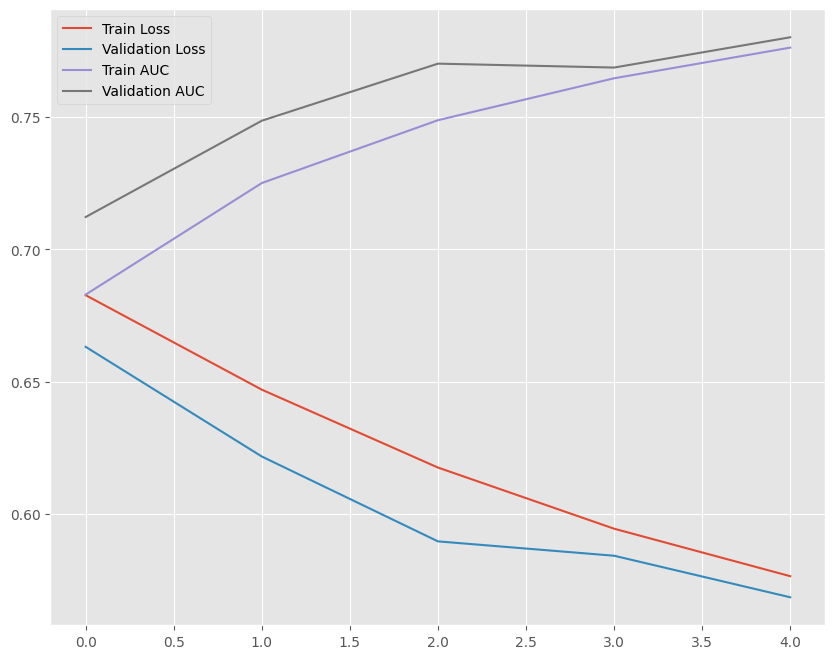

Validation AUC: 0.7790


In [35]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = base_layer_model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = base_layer_model.metrics_names.index('auc')
auc_score_baseline2 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline2:.4f}")

In [36]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_2 = {v.name: v.numpy() for v in base_layer_model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_2 = add_noise_to_weights(model_weights_dict_2, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [37]:
node_2 = sy.orchestra.launch(name="test-domain-2", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-2 server on 0.0.0.0:51584
Waiting for server to start

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


..............

INFO:     Started server process [47113]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:51584 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/b626124c319343c882a448dac2d6953d.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=da9606dd49df49b3bdd94889ed309eee in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:59473 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [38]:
domain_client_2 = node_2.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:59475 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:59475 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-2: High-side Domain> as GUEST
INFO:     127.0.0.1:59475 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:59475 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:59479 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-2: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [39]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_2)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 9fdab97c00f24cd9851a3d02cfdccc1a


In [40]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client_2.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:59481 - "POST /api/v2/api_call HTTP/1.1" 200 OK
9fdab97c00f24cd9851a3d02cfdccc1a


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [41]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:59483 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59485 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59487 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [42]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local_2 = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/ae244cd354de4308890dc956bea99327.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=4e2279b33cbd492dbaf47a9695ea9f95 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_223: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:59498 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59500 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_223
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [43]:
request = domain_client_2.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:59511 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59515 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:59517 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59519 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59521 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59524 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59526 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59528 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59530 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [44]:
request.approve()

INFO:     127.0.0.1:59515 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:59532 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59534 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59536 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59540 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59542 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59544 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59546 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-2
INFO:     127.0.0.1:59548 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request d6e6fcd4be2f431c9eace8e03f64bcd6 changes applied

In [45]:
domain_client_2._api = None
_ = domain_client_2.api

INFO:     127.0.0.1:59515 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [46]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local_2 = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/08547a0dba1d4271902c50057c5b5d1d.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=9cef6bdd3a08453e8cd6e448926d0937 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_1974: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:59554 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:59556 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_1974
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [47]:
if node_2.node_type.value == "python":
    node_2.land()

## Data Scientist

In [48]:
weights1 = weights_local
weights2 = weights_local_2

In [49]:
import jax.numpy as jnp

def combine_weights(weights1, weights2):
    """Combines two sets of weights by averaging."""
    global_weights = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(weights2.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_weights2 = weights2[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_weights2.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights[key] = (layer_weights1 + layer_weights2) / 2
    
    return global_weights


In [50]:
global_weights = combine_weights(weights1, weights_local_2)

# Data Owner 1 with Global Model Base and Local Top Layer 

In [51]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [52]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

# Global Model Layer
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()
    for units in arch[:-1]:
        mlp.add(Dense(units, activation=activation))
    mlp.add(Dense(arch[-1], activation=out_activation))
    return mlp

class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interacation=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)
        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)
        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2) if self.self_interaction else int(len(inputs) * (len(inputs) - 1) / 2)
        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions

class BaseDLRM(Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot):
        super(BaseDLRM, self).__init__()
        self.emb = [Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)
        return dense_x, emb_x

    def update_global_weights(self, global_weights):
        #Updates the model's weights with the provided global weights.
        self.set_weights(global_weights)

class PersonalizationModel(Model):
    def __init__(self, arch_top):
        super(PersonalizationModel, self).__init__()
        self.top_nn = MLP(arch_top, out_activation='sigmoid')

    def call(self, inputs):
        dense_x, emb_x = inputs
        z = concatenate([dense_x] + emb_x, axis=1)
        p = self.top_nn(z)
        return p

class FederatedPersonalizedModel(Model):
    def __init__(self, base_model, arch_top):
        super(FederatedPersonalizedModel, self).__init__()
        self.base_model = base_model
        self.personalization_model = PersonalizationModel(arch_top)

    def call(self, inputs):
        base_output = self.base_model(inputs)
        final_output = self.personalization_model(base_output)
        return final_output


In [53]:
base_model = BaseDLRM(embedding_sizes, embedding_dim, arch_bot)
personalized_model = FederatedPersonalizedModel(base_model, arch_top)



# Assuming 'base_model' and 'personalized_model' are correctly defined as before
personalized_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]  # Correctly pass metrics as a list
)


In [54]:
BATCH_SIZE = 128

history = personalized_model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 6s 8ms/step - loss: 0.5267 - accuracy: 0.7569 - auc: 0.8146 - val_loss: 0.4890 - val_accuracy: 0.7739 - val_auc: 0.8452
Epoch 2/5
427/427 [==============================] - 6s 13ms/step - loss: 0.4095 - accuracy: 0.8190 - auc: 0.8950 - val_loss: 0.4625 - val_accuracy: 0.7882 - val_auc: 0.8652
Epoch 3/5
427/427 [==============================] - 6s 14ms/step - loss: 0.2830 - accuracy: 0.8812 - auc: 0.9511 - val_loss: 0.4712 - val_accuracy: 0.7922 - val_auc: 0.8666
Epoch 4/5
427/427 [==============================] - 6s 14ms/step - loss: 0.2204 - accuracy: 0.9081 - auc: 0.9705 - val_loss: 0.4797 - val_accuracy: 0.8014 - val_auc: 0.8731
Epoch 5/5
427/427 [==============================] - 6s 15ms/step - loss: 0.1856 - accuracy: 0.9210 - auc: 0.9790 - val_loss: 0.5280 - val_accuracy: 0.7955 - val_auc: 0.8682


In [55]:
personalized_model.summary()

Model: "federated_personalized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_dlrm (BaseDLRM)        multiple                  579028    
                                                                 
 personalization_model (Per  multiple                  15426     
 sonalizationModel)                                              
                                                                 
Total params: 594454 (2.27 MB)
Trainable params: 594454 (2.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
results = personalized_model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 1s 3ms/step - loss: 0.7051 - accuracy: 0.7253 - auc: 0.7888
Loss: 0.7051197290420532, Accuracy: 0.7253411412239075, AUC: 0.7887747883796692


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.526727,0.756870,0.814643,0.489018,0.773910,0.845175
1,0.409483,0.818971,0.894963,0.462453,0.788201,0.865233
2,0.283028,0.881201,0.951098,0.471242,0.792232,0.866586
3,0.220366,0.908148,0.970468,0.479663,0.801392,0.873071
4,0.185561,0.920990,0.979038,0.527954,0.795529,0.868170


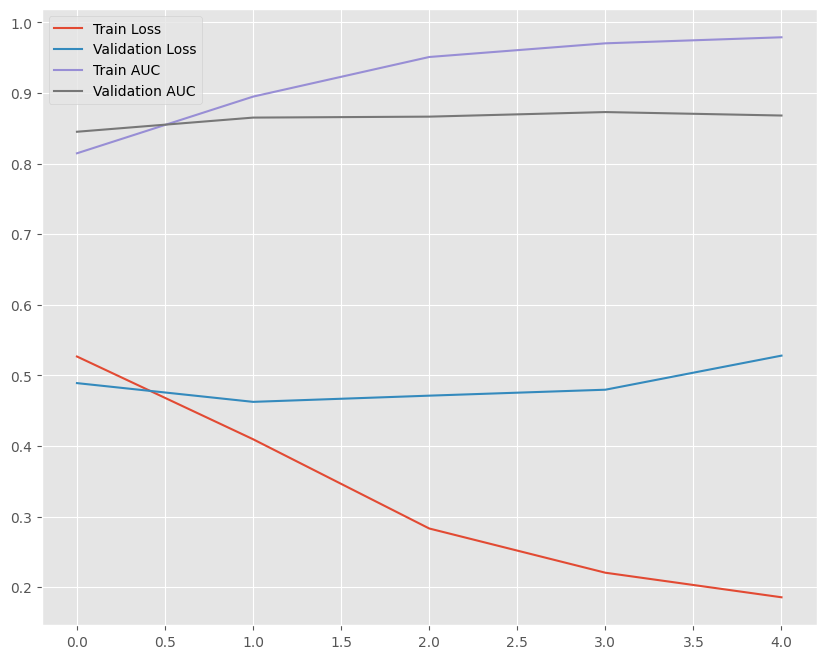

In [57]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [58]:
# Evaluate the model on the validation dataset
val_metrics = personalized_model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = personalized_model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 0.8665


In [59]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline1 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 125.15%


# Data Owner 2 with Global Model Base and Local Top Layer 

In [60]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [61]:
# Global Model Layer

embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()
    for units in arch[:-1]:
        mlp.add(Dense(units, activation=activation))
    mlp.add(Dense(arch[-1], activation=out_activation))
    return mlp

class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interacation=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)
        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)
        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2) if self.self_interaction else int(len(inputs) * (len(inputs) - 1) / 2)
        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions

class BaseDLRM(Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot):
        super(BaseDLRM, self).__init__()
        self.emb = [Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)
        return dense_x, emb_x

    def update_global_weights(self, global_weights):
        #Updates the model's weights with the provided global weights.
        self.set_weights(global_weights)

class PersonalizationModel(Model):
    def __init__(self, arch_top):
        super(PersonalizationModel, self).__init__()
        self.top_nn = MLP(arch_top, out_activation='sigmoid')

    def call(self, inputs):
        dense_x, emb_x = inputs
        z = concatenate([dense_x] + emb_x, axis=1)
        p = self.top_nn(z)
        return p

class FederatedPersonalizedModel(Model):
    def __init__(self, base_model, arch_top):
        super(FederatedPersonalizedModel, self).__init__()
        self.base_model = base_model
        self.personalization_model = PersonalizationModel(arch_top)

    def call(self, inputs):
        base_output = self.base_model(inputs)
        final_output = self.personalization_model(base_output)
        return final_output


In [62]:
base_model = BaseDLRM(embedding_sizes, embedding_dim, arch_bot)
personalized_model = FederatedPersonalizedModel(base_model, arch_top)



# Assuming 'base_model' and 'personalized_model' are correctly defined as before
personalized_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]  # Correctly pass metrics as a list
)


In [63]:
BATCH_SIZE = 128

history =personalized_model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 14s 25ms/step - loss: 0.5188 - accuracy: 0.7585 - auc: 0.8225 - val_loss: 0.4734 - val_accuracy: 0.7743 - val_auc: 0.8556
Epoch 2/5
427/427 [==============================] - 11s 26ms/step - loss: 0.4020 - accuracy: 0.8207 - auc: 0.8991 - val_loss: 0.4461 - val_accuracy: 0.8003 - val_auc: 0.8757
Epoch 3/5
427/427 [==============================] - 16s 38ms/step - loss: 0.2732 - accuracy: 0.8852 - auc: 0.9545 - val_loss: 0.4840 - val_accuracy: 0.7816 - val_auc: 0.8616
Epoch 4/5
427/427 [==============================] - 10s 23ms/step - loss: 0.2111 - accuracy: 0.9131 - auc: 0.9729 - val_loss: 0.4957 - val_accuracy: 0.7933 - val_auc: 0.8756
Epoch 5/5
427/427 [==============================] - 9s 22ms/step - loss: 0.1793 - accuracy: 0.9251 - auc: 0.9804 - val_loss: 0.4975 - val_accuracy: 0.8043 - val_auc: 0.8842


In [64]:
personalized_model.summary()

Model: "federated_personalized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_dlrm (BaseDLRM)        multiple                  579028    
                                                                 
 personalization_model (Per  multiple                  15426     
 sonalizationModel)                                              
                                                                 
Total params: 594454 (2.27 MB)
Trainable params: 594454 (2.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
results = personalized_model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 1s 4ms/step - loss: 0.7374 - accuracy: 0.7325 - auc: 0.7954
Loss: 0.7374005317687988, Accuracy: 0.7324846386909485, AUC: 0.7954269647598267


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.518836,0.758482,0.822457,0.473357,0.774276,0.855602
1,0.401951,0.820693,0.899126,0.446089,0.800293,0.875654
2,0.273154,0.885231,0.954542,0.483957,0.781605,0.861608
3,0.211065,0.913131,0.972917,0.495664,0.793331,0.875556
4,0.179266,0.925093,0.980396,0.497454,0.804324,0.884239


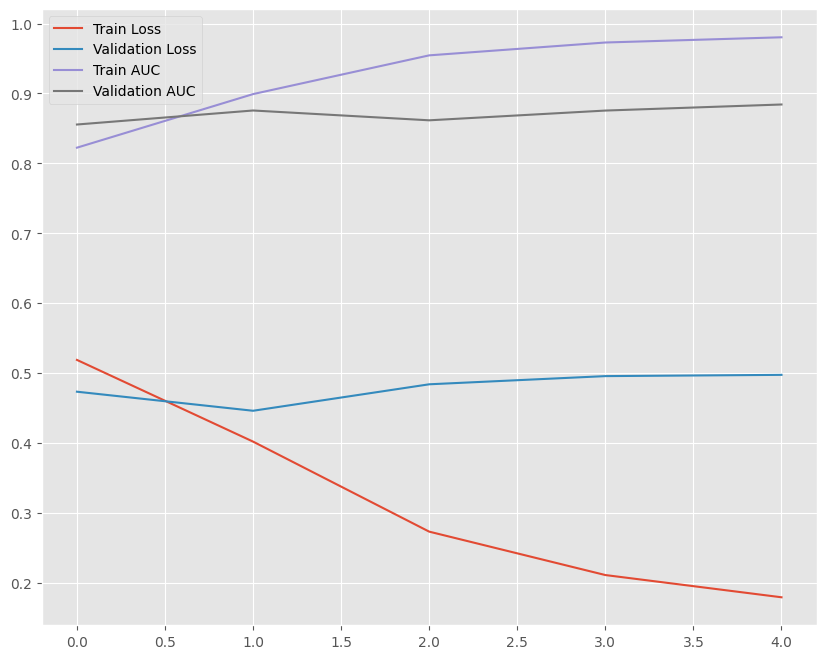

In [66]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [67]:
# Evaluate the model on the validation dataset
val_metrics = personalized_model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = personalized_model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")


Validation AUC: 0.8799


In [68]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline2 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 136.16%
